In [85]:
import vmo 
import vmo.analysis as van
import vmo.analysis.segmentation as vse
import csv
import numpy as np
np.set_printoptions(threshold='nan')

from collections import Counter

import math
import entropy
import matplotlib as mpl 

import matplotlib.pyplot as plt

import matplotlib.cm as cm
from matplotlib import patches
import plotly.plotly as py


import librosa

from nolds import lyap_e, lyap_r, corr_dim

import scipy as sc
import scipy.sparse as sp
from scipy.sparse import spdiags
import scipy.stats


import pylab 
import scipy.weave
import scipy.io.wavfile as wav

import operator

from pyunicorn.timeseries import RecurrencePlot, RecurrenceNetwork

#from python_speech_features import mfcc
#from python_speech_features import logfbank

from pylab import * # show, scatter, xlim, ylim
from random import randint
from random import randrange

import warnings
warnings.filterwarnings('ignore')
warnings.catch_warnings()

%matplotlib inline
%pylab inline

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!
Populating the interactive namespace from numpy and matplotlib


In [363]:
# subsection of the bifurcation diagram of the logistic map for for 3.4 <= R <= 3.55
N = 1
timeseries = [] # list of pairs (r,x)

#R=3.741  # bifurcation parameter
ts = np.empty(N)
ts[0] = 0.7

rs = np.linspace(2.8, 4, 100000) # 100 R values between 3.4 and 3.55
for R in rs:
    for i in range (N):
        x = ts[i-1]
        ts[i] = R * x * (1-x)
        timeseries.append([R, x])

print len(timeseries)


100000


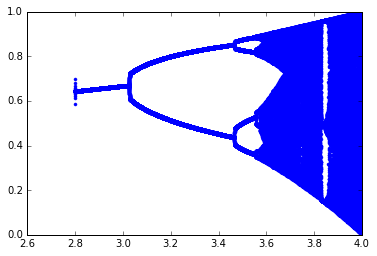

(100000, 2)


In [364]:
TS = np.array(timeseries)

pylab.plot(TS[:,0], TS[:,1], '.') # TS[:,0] are R values. TS[:,1] are x values

print TS.shape
#print TS[1:100,1]

(1000,)


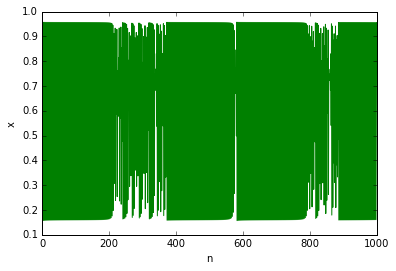

In [463]:
# time series of logistic map with transients discarded
n = 1000 # nb of iterations, length of time series

#x0 = 0.00079
#r=3.82842712 

def logisticmap(x0, r, T):  
    r = float(r)
   
    ts = np.empty(T)
    ts[0] = x0 

    for i in range (1,T):
        x = ts[i-1]
        ts[i] = r * x * (1-x)        
    return ts

r = 3.8284
x0 = 0.5
T = 1000
time_series = logisticmap(x0,r, T)
print time_series.shape

pylab.plot(time_series, 'g')
plt.xlabel('n')
plt.ylabel('x')


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Recurrence rate: 0.250076
Determinism: 0.94448280846
Laminarity: 0.00106767969609


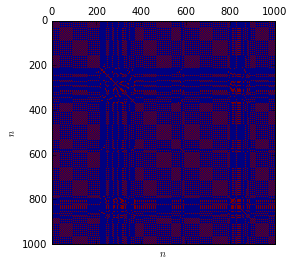

In [464]:
# RP from pyunicorn
rp = RecurrencePlot(time_series, dim=3, threshold = 0.05)
#  Show the recurrence plot
pylab.matshow(rp.recurrence_matrix())
pylab.xlabel("$n$")
pylab.ylabel("$n$")


print "Recurrence rate:", rp.recurrence_rate()

#  Calculate some standard RQA measures
DET = rp.determinism(l_min=2)
LAM = rp.laminarity(v_min=2)

print "Determinism:", DET
print "Laminarity:", LAM

In [465]:
# time series standard embedding 
def timeseries_embedding(series=[], m=3, time_delay=1):    
    m = int(m) # m = embedding dimension = nb of columns in the embedded time series matrix
    time_delay = int(time_delay)
    
    n = len(series) 
    
    nb_vectors = n - (m-1) * time_delay # nb of vectors in the embedded time series matrix
    embedded = np.empty((nb_vectors, m), dtype="float32") # embedded series has nb_vectors rows and m columns

    #print embedded.shape
    for j in range(0, m):
        idx = j * time_delay
        
        for k in range(0,nb_vectors):
            embedded[k,j] = series[idx]
            idx += 1
    return embedded

In [466]:
# embedding of time series for the following parameters:
#r = 3.8284
#x0 = 0.7
#T = 1000

dim = 3
tau = 1

embedded_timeseries =  timeseries_embedding(time_series, dim, tau)
#print embedded_timeseries.shape

In [467]:
r_threshold = (0, 1.01, 0.01)

threshold = vmo.find_threshold(embedded_timeseries, r=r_threshold, dim = dim)
print(threshold[0][1])

0.01


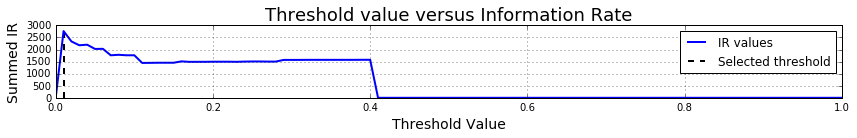

In [468]:
ideal_t = threshold[0][1]
x_t = [i[1] for i in threshold[1]]
y_t = [i[0] for i in threshold[1]]

plt.figure(figsize=(12,2))
plt.plot(x_t, y_t, linewidth = 2)
plt.hold('on')
plt.vlines(ideal_t, 0.0, max(y_t), colors = 'k',linestyle = 'dashed',linewidth = 2)
plt.grid('on')
plt.legend(['IR values', 'Selected threshold'], loc=1)
plt.title('Threshold value versus Information Rate', fontsize = 18)
plt.xlabel('Threshold Value',fontsize = 14)
plt.ylabel('Summed IR', fontsize = 14)
plt.tight_layout()

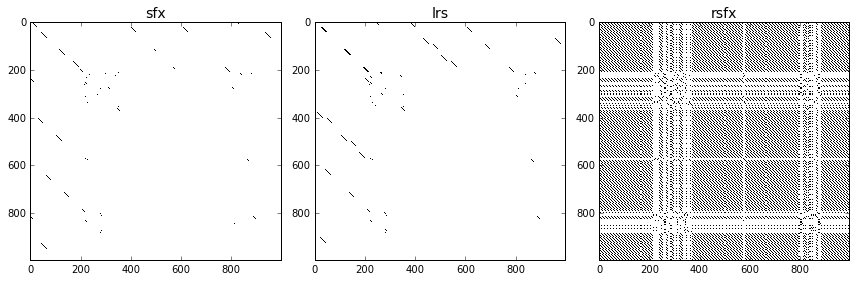

In [469]:
ts_vmo = vmo.build_oracle(embedded_timeseries, flag='a', threshold=ideal_t, dim=dim)

methods = ['sfx', 'lrs', 'rsfx']

#print(cqt_stack.T)

plt.figure(figsize = (12,4))
for i,m in enumerate(methods):
    recurrence_vmo = van.create_selfsim(ts_vmo, method=m)
    
    plt.subplot(1,3,i+1)
    plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Greys')
    
    plt.title(m, fontsize=14)
plt.tight_layout()

RR = 0.00274496889571
DET= 0.997073884418
Average diagonal line length= 22.7166666667
Longest Diagonal Length (L_max) 219.0
Divergence (DIV)= 0.00456621004566
Entropy diagonal lines (L_entr): 0.00236646153148
Laminarity (LAM)= 0.0
Trapping Time: Average Vertical Line Length (TT)= NA
Longest Vertical Line 1.0
Entropy vertical lines (V_entr): 0.0273116379745
RATIO: (DET/RR)= 363.236860708
LAM / DET= 0.0
Average White Vertical Line Length (W): 268.298487304
Longest White Vertical Line Length (W_max): 998.0
Entropy white vertical lines (W_entr): 0.0647550059904


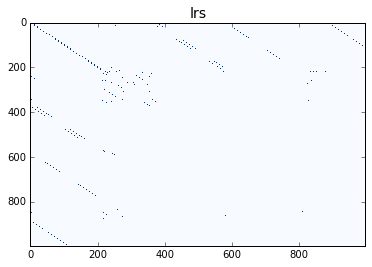

In [470]:
recurrence_vmo = van.create_selfsim(ts_vmo, method='lrs')

plt.figure(figsize = (6,4))
plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Blues')
plt.title('lrs', fontsize=14)


####################################################################

# RECURRENCE RATE
ln= len(recurrence_vmo)
RR = (np.sum(recurrence_vmo))/float(ln*ln)

####################################################################
# DIAGONALS
newd = {}
mat = np.zeros((recurrence_vmo.shape[0]*2+1,recurrence_vmo.shape[1]))

for ii in range(-len(recurrence_vmo), len(recurrence_vmo)):    
    newd[ii]= np.diagonal(recurrence_vmo, offset = ii) 
 
for i in range (-len(recurrence_vmo), len(recurrence_vmo)):   
    for j in range(len(newd[i])):
        mat[i+len(recurrence_vmo),j] = newd[i][j]    
 
diag_idx = 0
diagonals = np.zeros(recurrence_vmo.size)
for drow in range(0, len(mat)):    
    diag_sum = 0
    for dcol in range(0, mat.shape[1]):
        if (mat[drow,dcol] == 1):
            diag_sum += 1           
            
        if (mat[drow,dcol] == 0):
            if (diag_sum > 0):
                diagonals[diag_idx] = diag_sum
                diag_idx += 1
                diag_sum = 0
    if (diag_sum > 0):
        diagonals[diag_idx] = diag_sum;
        diag_idx += 1        
        
dia_cnt = 0
dia_sum = 0
for indx in range(0, len(diagonals)):
    if (diagonals[indx] >= 2):
        dia_sum += diagonals[indx]
        dia_cnt += 1
        


if (dia_cnt > 0):
    av_diag = dia_sum / dia_cnt
else: 
    av_diag = 'NA'


####################################################################
# DETERMINISM      
nume = dia_sum #np.sum(L)
denom = np.sum(recurrence_vmo)
if (denom > 0):
    DET =  nume / denom
else: 
    DET = "NA"
    print DET

  
    
####################################################################
#find vertical lines
idx = 0
vertical = np.zeros(recurrence_vmo.size)
for c in range(0, recurrence_vmo.shape[1]):       
    s = 0
    for r in range(0, len(recurrence_vmo)):
        if (recurrence_vmo[r,c] == 1):
            s += 1           
            
        if (recurrence_vmo[r,c] == 0):
            if (s > 0):
                vertical[idx] = s
                idx += 1
                s = 0
    if (s > 0):
        vertical[idx] = s;
        idx += 1
                      
    
vcnt = 0
vsum = 0
for V in range(0, len(vertical)):
    if (vertical[V] >= 2):
        vsum += vertical[V]
        vcnt += 1
      
 
        
####################################################################
# LAMINARITY

if (np.sum(recurrence_vmo) != 0):
    LAM = vsum / np.sum(recurrence_vmo)
else:
    LAM = 'NA'




####################################################################
# TRAPPING TIME
if (vcnt > 0):
    TT = vsum /vcnt
else: 
    TT = 'NA'

####################################################################
# find white vertical lines
indx = 0
white = np.zeros(recurrence_vmo.size)
for col in range(0, recurrence_vmo.shape[1]):    
    sm = 0
    for row in range(0, len(recurrence_vmo)):
        if (recurrence_vmo[row,col] == 0):
            sm += 1     
        if (recurrence_vmo[row,col] == 1):
            if (sm > 0):
                white[indx] = sm
                indx += 1
                sm = 0
    if (sm > 0):
        white[indx] = sm;
        indx += 1
        
wcnt = 0
wsum = 0
for w in range(0, len(white)):
    if (white[w] >= 2):
        wsum += white[w]
        wcnt += 1

if (wcnt > 0):
    W = wsum /wcnt
else: 
    W = 'NA'
    
    
####################################################################

W_max = white.max()  # longest white vertical line


####################################################################

# Longest Diagonal Length without the Line of Identity (LOI):
newdiag = np.copy(diagonals) # copy array into array newdiag
max_idx= np.argmax(newdiag)  # get the index of the LOI

newdiag[max_idx] = -1 # remove the index of LOI
L_max = newdiag.max()  # get the second longest diagonal


####################################################################

# Divergence

if (L_max > 0):
    DIV = np.divide(1,L_max)
else:
    DIV = 'NA'
####################################################################

# Longest Vertical Line
V_max = vertical.max()

####################################################################

# DET / RR

if (RR > 0):
    DET_RR_ratio = np.divide(DET, RR)
else:
    RR = 'NA'



####################################################################


####################################################################
# LAM / DET

if (DET > 0): 
    LAM_DET_ratio = np.divide(LAM, DET)
else:
    LAM_DET_ratio = 'NA'

####################################################################

# Entropy of diagonal line lengths
u, inv = np.unique(diagonals, return_inverse=True)
n = np.bincount(inv)

L_entr = 0

for i in range(0, len(n)):
    L_entr += - (float(n[i])/float(len(diagonals))) * math.log(float(n[i])/float(len(diagonals)),2)

#print entropy.shannon_entropy('diagonals')
####################################################################

# Entropy of verticals
uv, vinv = np.unique(vertical, return_inverse=True)
nv = np.bincount(vinv)

V_entr = 0

for iv in range(0, len(nv)):
    V_entr += - (float(nv[iv])/float(len(vertical))) * math.log(float(nv[iv])/float(len(vertical)),2)

#shan = entropy.shannon_entropy('vertical')

#print shan

#print V_entr
####################################################################

# Entropy of white vertical lines
w, winv = np.unique(white, return_inverse=True)
wn = np.bincount(winv)

W_entr = 0

for w in range(0, len(wn)):
    W_entr += - (float(wn[w])/float(len(white))) * math.log(float(wn[w])/float(len(white)),2)

#white_shan = entropy.shannon_entropy('white')

####################################################################


print "RR =", RR
print "DET=", DET
print "Average diagonal line length=",  av_diag 
print "Longest Diagonal Length (L_max)", L_max
print "Divergence (DIV)=", DIV
print "Entropy diagonal lines (L_entr):", L_entr
print "Laminarity (LAM)=", LAM
print "Trapping Time: Average Vertical Line Length (TT)=", TT
print "Longest Vertical Line", V_max
print "Entropy vertical lines (V_entr):", V_entr
print "RATIO: (DET/RR)=", DET_RR_ratio
print "LAM / DET=", LAM_DET_ratio
print "Average White Vertical Line Length (W):", W
print "Longest White Vertical Line Length (W_max):", W_max
print "Entropy white vertical lines (W_entr):", W_entr


In [246]:
# Function: Lyapunov exponents of time series obtained for different r values of the bifurcation points
def lyapunov_exponent(timeseries, R):
    lyap_exp = 0    
    lyap_exp += log(abs(R - 2 * R * timeseries)).mean()
    return lyap_exp


KS=  2130.89587653


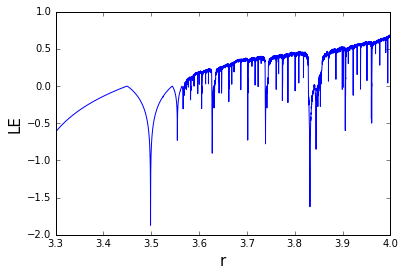

In [471]:
# Plotting Lyapunov Exponent for the logistic map for 3.3 <= r <= 4.0

rvalues = np.empty(0)
rvalues = np.linspace(3.3, 4.0, 10000)
bifr_len = len(rvalues)
time_S = [] # list of [r, timeseries]
le = np.zeros(len(rvalues))
x0 = 0.8
T = 1000

idx = 0
for b in range (0,bifr_len):
    tseries = logisticmap(x0, rvalues[b], T)
    time_S.append([rvalues[b], tseries]) #save r and corresponding timeseries
    tseries = 0

    
for l in range(0,len(time_S)):
    le[idx] = lyapunov_exponent(time_S[l][1], rvalues[l])    
    idx += 1
    

# set up the plot
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE', fontsize=15)
r_min=3.3  # range
r_max=4.0
x0=0.7    #initial condition


# plots the lyapunov exponent
plt.axis([r_min, r_max,-2, 1.0])
plt.plot(rvalues, le,'b-',markersize=8)


# Compute the Kolmogorov-Sinai entropy from the the Lyapunov Exponents

pos = le[le>0]

KS = sum(pos)
print "KS= ", KS

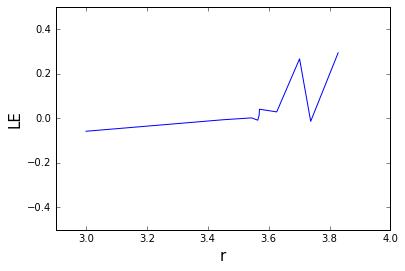

In [472]:
# plotting Lyapunov Exponent for specific r values where bifurcation points happen

#the values of r where bifurcation points happen
bif_rvalues = [3.0, 3.449489, 3.544090, 3.564407, 3.568750, 3.56969, 3.56989, 3.569934, 3.569943, 3.569945, 3.569945, 3.569945, 3.626553, 3.701640, 3.738172, 3.828427]


bifr_len = len(bif_rvalues)
time_S = [] # list of [r, timeseries]
le2 = np.zeros(len(bif_rvalues))
x0 = 0.8
T = 100

idx = 0
for b in range (0,bifr_len):
    tseries = logisticmap(x0, bif_rvalues[b], T)
    time_S.append([bif_rvalues[b], tseries]) #save r and corresponding timeseries
    tseries = 0

    
for l in range(0,len(time_S)):
    le2[idx] = lyapunov_exponent(time_S[l][1], bif_rvalues[l])    
    idx += 1
    

# plot settings
plt.figure()
plt.xlabel(r'r',fontsize=15)
plt.ylabel('LE', fontsize=15)
r_min=2.9  # range
r_max=4.0



# plots the lyapunov exponent
plt.axis([r_min, r_max,-0.5, 0.5])
plt.plot(bif_rvalues, le2,'b-',markersize=8)





In [473]:
# Compute the Kolmogorov-Sinai entropy from the the Lyapunov Exponents

pos = le2[le2>0]

KS = sum(pos)
print KS


0.877196833631


In [37]:
# compute the positive Lyapunov exponents according to Rosenstein et. al algorithm.
#timeSeries = TS[100:250,1]
#timeSeries = timeSeries.astype("float32")

#pos_lyap_exp = 0.0
#pos_lyap_exp = lyap_r(data=timeSeries, emb_dim=10,tau=10)
#print pos_lyap_exp

#pylab.plot(lyap_spectrum)
#pylab.show()


In [440]:
# compute the Lyapunov spectrum according to Eckmann et. al algorithm.
#timeSeries = np.copy(TS[:,1])
#timeSeries = TS[10:99950,1]
#lyap_spectrum = lyap_e(data=timeSeries, emb_dim=10, tau=10)
#print lyap_spectrum
#pylab.plot(lyap_spectrum)
#pylab.show()



In [ ]:
# computer the correlation dimension
timeSeries = TS[500:1000,1]
K2 = corr_dim(data=timeSeries,emb_dim=10)
print K2